In [4]:
import h5py

# 1. 打开H5文件（'r'表示只读模式，避免修改原文件）
with h5py.File("/root/autodl-tmp/WWADL/imu/0_1_1.h5", "r") as f:
    # 2. 遍历所有数据集（H5文件可能包含多个数据集）
    for dataset_name in f.keys():
        # 3. 获取数据集对象
        dataset = f[dataset_name]
        # 4. 获取维度（.shape）和数据类型（.dtype，可选）
        data_shape = dataset.shape
        data_type = dataset.dtype
        # 输出结果
        print(f"数据集 '{dataset_name}'：")
        print(f"  维度：{data_shape}")
        print(f"  数据类型：{data_type}\n")
        # 查看duration的内容（标量专用读取方式）
        if dataset_name == 'duration':
            duration_data = dataset[()]  # 标量用[()]读取
            print(f"  数据内容：{duration_data}\n")
        else:
            print("\n")

数据集 'data'：
  维度：(5, 2950, 6)
  数据类型：float64



数据集 'duration'：
  维度：()
  数据类型：int64

  数据内容：59

数据集 'label'：
  维度：(8, 4)
  数据类型：int64





In [5]:
import h5py

# 1. 打开H5文件（'r'表示只读模式，避免修改原文件）
with h5py.File("/root/autodl-tmp/WWADL/all_30_3/train_data.h5", "r") as f:
    # 2. 遍历所有数据集（H5文件可能包含多个数据集）
    for dataset_name in f.keys():
        # 3. 获取数据集对象
        dataset = f[dataset_name]
        # 4. 获取维度（.shape）和数据类型（.dtype，可选）
        data_shape = dataset.shape
        data_type = dataset.dtype
        # 输出结果
        print(f"数据集 '{dataset_name}'：")
        print(f"  维度：{data_shape}")
        print(f"  数据类型：{data_type}\n")

数据集 'imu'：
  维度：(9660, 2048, 5, 6)
  数据类型：float64

数据集 'wifi'：
  维度：(9660, 2048, 3, 3, 30)
  数据类型：float64



In [1]:
import json
from pathlib import Path

import numpy as np


def load_results(json_path_or_obj):
    """
    json_path_or_obj:
      - str / Path: 指向你保存的这个大 JSON 文件
      - list: 直接传你贴出来的 Python list 对象
    """
    if isinstance(json_path_or_obj, (str, Path)):
        with open(json_path_or_obj, "r", encoding="utf-8") as f:
            return json.load(f)
    return json_path_or_obj


def summarize_map_across_folds(results, splits=("test_window", "test_full")):
    """
    计算：
      1) 各 split 的 avg_mAP 在 folds 维度上的均值（以及可选 std）
      2) 各 split 的每个 tIoU 上的 mAP（mAPs）在 folds 维度上的逐元素均值
    """
    out = {}

    for split in splits:
        # 收集每个 fold 的 avg_mAP
        avg_maps = []
        per_tiou_maps = []
        tious_ref = None

        for r in results:
            if split not in r:
                continue
            s = r[split]
            avg_maps.append(float(s["avg_mAP"]))
            per_tiou_maps.append([float(x) for x in s["mAPs"]])

            if tious_ref is None:
                tious_ref = [float(x) for x in s["tious"]]

        if not avg_maps:
            out[split] = None
            continue

        avg_maps_np = np.array(avg_maps, dtype=np.float64)
        per_tiou_np = np.array(per_tiou_maps, dtype=np.float64)

        out[split] = {
            "num_folds": int(len(avg_maps)),
            "mean_avg_mAP": float(avg_maps_np.mean()),
            "std_avg_mAP": float(avg_maps_np.std(ddof=1)) if len(avg_maps_np) > 1 else 0.0,
            "tious": tious_ref,
            "mean_mAPs_per_tiou": per_tiou_np.mean(axis=0).tolist(),
        }

    return out


def pretty_print_summary(summary):
    for split, s in summary.items():
        if s is None:
            print(f"[{split}] no data")
            continue

        print(f"\n[{split}] folds={s['num_folds']}")
        print(f"  mean(avg_mAP) = {s['mean_avg_mAP']:.6f}   std = {s['std_avg_mAP']:.6f}")
        print("  mean mAP @ tIoU:")
        for tiou, m in zip(s["tious"], s["mean_mAPs_per_tiou"]):
            print(f"    tIoU={tiou:.1f}: {m:.6f}")


if __name__ == "__main__":
    results = load_results("/home/lipei/project/WSDDN/test_results/Opportunity/pcl_0106/loso_report.json")


    summary = summarize_map_across_folds(results, splits=("test_window", "test_full"))
    pretty_print_summary(summary)



tIoU阈值: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

==== 每个tIoU对应的mAP ====
tIoU=0.1 → mAP=0.6702
tIoU=0.2 → mAP=0.6623
tIoU=0.3 → mAP=0.6413
tIoU=0.4 → mAP=0.6075
tIoU=0.5 → mAP=0.5363
tIoU=0.6 → mAP=0.4507
tIoU=0.7 → mAP=0.3155
tIoU=0.8 → mAP=0.1411
tIoU=0.9 → mAP=0.0451

平均mAP（0.1~0.9）: 0.4522


In [3]:
import json
import numpy as np
import pandas as pd
from collections import defaultdict


def load_data(pred_path, gt_path):
    """加载预测结果和真实标注"""
    with open(pred_path, 'r', encoding='utf-8') as f:
        pred_data = json.load(f)
    with open(gt_path, 'r', encoding='utf-8') as f:
        gt_data = json.load(f)
    return pred_data, gt_data


def segment_iou(target_seg, candidate_segs):
    """计算单个目标片段与多个候选片段的tIoU"""
    tiou_list = []
    for cand_seg in candidate_segs:
        inter_start = max(target_seg[0], cand_seg[0])
        inter_end = min(target_seg[1], cand_seg[1])
        inter = max(0, inter_end - inter_start)
        union = (cand_seg[1] - cand_seg[0]) + (target_seg[1] - target_seg[0]) - inter
        tiou = inter / union if union != 0 else 0.0
        tiou_list.append(tiou)
    return np.array(tiou_list)


def compute_ap(gt_segs, pred_segs, tiou_thresholds):
    """计算单个类别+视频的AP"""
    if len(pred_segs) == 0:
        return np.zeros(len(tiou_thresholds))

    pred_sorted = sorted(pred_segs, key=lambda x: x['score'], reverse=True)
    n_gt = len(gt_segs)
    n_pred = len(pred_sorted)

    tp = np.zeros((len(tiou_thresholds), n_pred))
    fp = np.zeros((len(tiou_thresholds), n_pred))
    matched_gt = np.zeros((len(tiou_thresholds), n_gt), dtype=bool)

    for pred_idx, pred in enumerate(pred_sorted):
        pred_seg = pred['segment']
        tiou_arr = segment_iou(pred_seg, gt_segs)

        for t_idx, tiou_thr in enumerate(tiou_thresholds):
            max_tiou_idx = np.argmax(tiou_arr)
            max_tiou = tiou_arr[max_tiou_idx]
            if max_tiou >= tiou_thr and not matched_gt[t_idx, max_tiou_idx]:
                tp[t_idx, pred_idx] = 1
                matched_gt[t_idx, max_tiou_idx] = True
            else:
                fp[t_idx, pred_idx] = 1

    tp_cumsum = np.cumsum(tp, axis=1)
    fp_cumsum = np.cumsum(fp, axis=1)
    recall = tp_cumsum / n_gt if n_gt > 0 else np.zeros_like(tp_cumsum)
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)

    ap = np.zeros(len(tiou_thresholds))
    for t_idx in range(len(tiou_thresholds)):
        mpre = np.hstack([[0], precision[t_idx], [0]])
        mrec = np.hstack([[0], recall[t_idx], [1]])
        for i in range(len(mpre)-2, -1, -1):
            mpre[i] = max(mpre[i], mpre[i+1])
        idx = np.where(mrec[1:] != mrec[:-1])[0] + 1
        ap[t_idx] = np.sum((mrec[idx] - mrec[idx-1]) * mpre[idx])
    return ap


def main(pred_path, gt_path):
    # 1. 加载数据
    pred_data, gt_data = load_data(pred_path, gt_path)
    pred_results = pred_data['results']
    gt_database = gt_data['database']

    # 2. 构建类别→视频→片段的映射
    gt_by_label_video = defaultdict(lambda: defaultdict(list))  # {动作: {视频ID: [真实片段]}}
    pred_by_label_video = defaultdict(lambda: defaultdict(list))  # {动作: {视频ID: [预测片段]}}

    # 处理真实标注
    for video_id, video_info in gt_database.items():
        video_key = video_id.split('.')[0]  # 提取视频ID（去除文件后缀）
        for ann in video_info['annotations']:
            label = ann['label']
            seg = ann['segment']
            gt_by_label_video[label][video_key].append(seg)

    # 处理预测结果
    for video_key, preds in pred_results.items():
        for pred in preds:
            label = pred['label']
            seg = pred['segment']
            score = pred['score']
            pred_by_label_video[label][video_key].append({'segment': seg, 'score': score})

    # 3. 定义tIoU阈值（0.1~0.9，步长0.1）
    tiou_thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
    print(f"tIoU阈值: {tiou_thresholds}\n")

    # 4. 按动作计算AP
    all_labels = sorted(gt_by_label_video.keys())  # 所有动作类别
    ap_matrix = np.zeros((len(tiou_thresholds), len(all_labels)))  # [tIoU数量, 动作数量]

    # 打印每个动作的AP表头
    tiou_headers = [f"tIoU={t:.1f}" for t in tiou_thresholds]
    print(f"{'动作名称':<20} " + " ".join([f"{h:<8}" for h in tiou_headers]) + "  平均AP")
    print("-" * (20 + 8 * len(tiou_thresholds) + 10))

    for label_idx, label in enumerate(all_labels):
        # 计算该动作在所有视频中的AP，再取平均
        video_aps = []
        for video_key in gt_by_label_video[label]:
            gt_segs = gt_by_label_video[label][video_key]
            pred_segs = pred_by_label_video[label].get(video_key, [])
            video_ap = compute_ap(gt_segs, pred_segs, tiou_thresholds)
            video_aps.append(video_ap)

        # 该动作的AP为所有视频的平均值
        label_ap = np.mean(video_aps, axis=0) if video_aps else np.zeros_like(tiou_thresholds)
        ap_matrix[:, label_idx] = label_ap

        # 计算该动作的平均AP（所有tIoU下的均值）
        avg_label_ap = np.mean(label_ap)

        # 打印该动作的结果
        ap_strs = [f"{ap:.4f}" for ap in label_ap]
        print(f"{label:<20} " + " ".join([f"{s:<8}" for s in ap_strs]) + f"  {avg_label_ap:.4f}")

    # 5. 计算整体mAP
    mAP_per_tiou = np.mean(ap_matrix, axis=1)
    average_mAP = np.mean(mAP_per_tiou)

    # 6. 打印整体结果
    print("\n" + "-" * (20 + 8 * len(tiou_thresholds) + 10))
    print(f"{'整体mAP':<20} " + " ".join([f"{m:.4f}" for m in mAP_per_tiou]) + f"  {average_mAP:.4f}")


if __name__ == "__main__":
    # 替换为你的文件路径
    # PRED_PATH = "./test_results/predictions.json"  # 预测结果路径
    #
    PRED_PATH = "/root/WSDDN/test_results/emmil_imu/emmil_predictions.json"
    GT_PATH = "/root/autodl-tmp/WWADL/all_30_3/imu_annotations.json"  # 真实标注路径
    main(PRED_PATH, GT_PATH)

tIoU阈值: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

动作名称                 tIoU=0.1 tIoU=0.2 tIoU=0.3 tIoU=0.4 tIoU=0.5 tIoU=0.6 tIoU=0.7 tIoU=0.8 tIoU=0.9  平均AP
------------------------------------------------------------------------------------------------------
Answering Phone      1.0000   1.0000   1.0000   0.9048   0.8363   0.7363   0.4702   0.1607   0.0179    0.6807
Cutting Fruit        0.9464   0.9464   0.9226   0.8690   0.7607   0.6137   0.4533   0.1964   0.0833    0.6436
Drinking Water       0.9795   0.9795   0.9658   0.9384   0.8155   0.7121   0.4890   0.2014   0.0712    0.6836
Eating Fruit         0.9733   0.9733   0.8667   0.7400   0.5847   0.5347   0.4427   0.2033   0.0133    0.5924
Getting Out of Bed   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000    0.0000
Lying Down           0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000    0.0000
Lying Still          0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000 

In [2]:
import json
import numpy as np
from collections import defaultdict


def load_data(pred_path, gt_path):
    with open(pred_path, "r", encoding="utf-8") as f:
        pred_data = json.load(f)
    with open(gt_path, "r", encoding="utf-8") as f:
        gt_data = json.load(f)
    return pred_data, gt_data


def segment_iou(target_seg, candidate_segs):
    tiou_list = []
    for cand_seg in candidate_segs:
        inter_start = max(target_seg[0], cand_seg[0])
        inter_end = min(target_seg[1], cand_seg[1])
        inter = max(0.0, inter_end - inter_start)
        union = (
            (cand_seg[1] - cand_seg[0])
            + (target_seg[1] - target_seg[0])
            - inter
        )
        tiou = inter / union if union > 0 else 0.0
        tiou_list.append(tiou)
    return np.array(tiou_list)


def compute_ap_from_pr(precision, recall):
    """标准 AP 计算（插值），和 PASCAL / ActivityNet 风格一致"""
    mpre = np.concatenate(([0.0], precision, [0.0]))
    mrec = np.concatenate(([0.0], recall, [1.0]))

    # precision 从后往前做 envelope
    for i in range(len(mpre) - 2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i + 1])

    # 只在 recall 变化的点积分
    idx = np.where(mrec[1:] != mrec[:-1])[0] + 1
    ap = np.sum((mrec[idx] - mrec[idx - 1]) * mpre[idx])
    return ap


def evaluate_imu(pred_path, gt_path, subset_filter="test"):
    # 1. 读 JSON
    pred_data, gt_data = load_data(pred_path, gt_path)
    pred_results = pred_data["results"]
    gt_database = gt_data["database"]

    # 2. 构建 GT 索引：class -> vid -> [segments]
    gt_by_label_vid = defaultdict(lambda: defaultdict(list))
    num_gts_per_label = defaultdict(int)

    for video_id, vinfo in gt_database.items():
        subset = vinfo.get("subset", "test")
        if subset_filter is not None and subset != subset_filter:
            continue

        vid = video_id.split(".")[0]

        for ann in vinfo["annotations"]:
            label = ann["label"]
            seg = ann["segment"]  # 假设已是“秒”或已统一好单位
            gt_by_label_vid[label][vid].append(seg)
            num_gts_per_label[label] += 1

    # 3. 构建预测索引：class -> list of {vid, segment, score}
    pred_by_label = defaultdict(list)

    for video_key_raw, preds in pred_results.items():
        vid = video_key_raw.split(".")[0]
        for pred in preds:
            label = pred["label"]
            seg = pred["segment"]
            score = float(pred["score"])
            pred_by_label[label].append(
                {"video_id": vid, "segment": seg, "score": score}
            )

    tiou_thresholds = np.round(np.arange(0.1, 1.0, 0.1), 1)
    print("tIoU 阈值:", tiou_thresholds, "\n")

    all_labels = sorted(gt_by_label_vid.keys())
    ap_matrix = np.zeros((len(tiou_thresholds), len(all_labels)))

    # 打印表头
    tiou_headers = [f"tIoU={t:.1f}" for t in tiou_thresholds]
    print(f"{'动作名称':<20} " + " ".join([f"{h:<8}" for h in tiou_headers]) + "  平均AP")
    print("-" * (20 + 8 * len(tiou_thresholds) + 10))

    for li, label in enumerate(all_labels):
        n_gt = num_gts_per_label[label]
        if n_gt == 0:
            continue

        # 该类的所有预测（所有视频拼在一起）
        preds = pred_by_label.get(label, [])
        if len(preds) == 0:
            # 完全没预测该类
            label_ap = np.zeros(len(tiou_thresholds))
            ap_matrix[:, li] = label_ap
            print(f"{label:<20} " + " ".join(["0.0000  "]*len(tiou_thresholds)) + "  0.0000")
            continue

        # 按 score 全局排序
        preds_sorted = sorted(preds, key=lambda x: x["score"], reverse=True)
        n_pred = len(preds_sorted)

        tp = np.zeros((len(tiou_thresholds), n_pred))
        fp = np.zeros((len(tiou_thresholds), n_pred))

        # 为每个视频、每个阈值记录哪些 GT 已经被匹配
        matched_gt = {
            t_idx: {vid: np.zeros(len(gts), dtype=bool)
                    for vid, gts in gt_by_label_vid[label].items()}
            for t_idx in range(len(tiou_thresholds))
        }

        # 逐个预测，从高 score 到低
        for p_idx, pred in enumerate(preds_sorted):
            vid = pred["video_id"]
            pred_seg = pred["segment"]
            if vid not in gt_by_label_vid[label]:
                # 在没有 GT 的视频里预测 → 一定是 FP
                fp[:, p_idx] = 1
                continue

            gt_segs = gt_by_label_vid[label][vid]
            tiou_arr = segment_iou(pred_seg, gt_segs)

            for t_idx, tiou_thr in enumerate(tiou_thresholds):
                max_tiou_idx = int(np.argmax(tiou_arr))
                max_tiou = tiou_arr[max_tiou_idx]
                if max_tiou >= tiou_thr and not matched_gt[t_idx][vid][max_tiou_idx]:
                    tp[t_idx, p_idx] = 1
                    matched_gt[t_idx][vid][max_tiou_idx] = True
                else:
                    fp[t_idx, p_idx] = 1

        # 计算该类在每个 tIoU 阈值下的 AP
        label_ap = np.zeros(len(tiou_thresholds))
        for t_idx in range(len(tiou_thresholds)):
            tp_cum = np.cumsum(tp[t_idx])
            fp_cum = np.cumsum(fp[t_idx])

            rec = tp_cum / (n_gt + 1e-8)
            prec = tp_cum / (tp_cum + fp_cum + 1e-8)

            label_ap[t_idx] = compute_ap_from_pr(prec, rec)

        ap_matrix[:, li] = label_ap
        avg_label_ap = float(np.mean(label_ap))

        ap_strs = [f"{ap:.4f}" for ap in label_ap]
        print(f"{label:<20} " + " ".join([f"{s:<8}" for s in ap_strs]) + f"  {avg_label_ap:.4f}")

    # 4. 整体 mAP
    mAP_per_tiou = np.mean(ap_matrix, axis=1)
    avg_mAP = float(np.mean(mAP_per_tiou))

    print("\n" + "-" * (20 + 8 * len(tiou_thresholds) + 10))
    print(f"{'整体mAP':<20} " + " ".join([f"{m:.4f}" for m in mAP_per_tiou]) + f"  {avg_mAP:.4f}")

    return mAP_per_tiou, avg_mAP


if __name__ == "__main__":
    # PRED_PATH = "./test_results/predictions.json"
    # PRED_PATH = "/root/WSDDN/test_results/emmil_imu/emmil_predictions.json"
    # PRED_PATH = "/root/WSDDN/test_results/wsddn_spatial_reg/predictions.json"
    PRED_PATH = "/root/WSDDN/test_results/wsddn_no_reg/predictions.json"
    # PRED_PATH = "/root/WSDDN/test_results/wscnet/wscnet_proposal_predictions.json"
    # PRED_PATH = "/root/WSDDN/test_results/emmil_imu_seg_nount/emmil_seg_predictions.json"
    GT_PATH = "/root/autodl-tmp/WWADL/all_30_3/imu_annotations.json"

    # 和 ANETdetection 保持一致：只评 test 子集
    evaluate_imu(PRED_PATH, GT_PATH, subset_filter="test")


tIoU 阈值: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] 

动作名称                 tIoU=0.1 tIoU=0.2 tIoU=0.3 tIoU=0.4 tIoU=0.5 tIoU=0.6 tIoU=0.7 tIoU=0.8 tIoU=0.9  平均AP
------------------------------------------------------------------------------------------------------
Answering Phone      0.9705   0.9705   0.9469   0.9128   0.8439   0.6686   0.3208   0.1191   0.0238    0.6419
Cutting Fruit        0.9203   0.9203   0.9203   0.8206   0.7956   0.4450   0.2254   0.0776   0.0000    0.5695
Drinking Water       0.8737   0.8737   0.8737   0.8240   0.7281   0.5366   0.1832   0.0508   0.0065    0.5500
Eating Fruit         0.9095   0.9095   0.9095   0.9095   0.7653   0.4931   0.2469   0.0962   0.0050    0.5827
Getting Out of Bed   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000    0.0000
Lying Down           0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000    0.0000
Lying Still          0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   0.000

[viz] saved figure to: /root/WSDDN/test_results/vis/vis_results/0_1_4.png


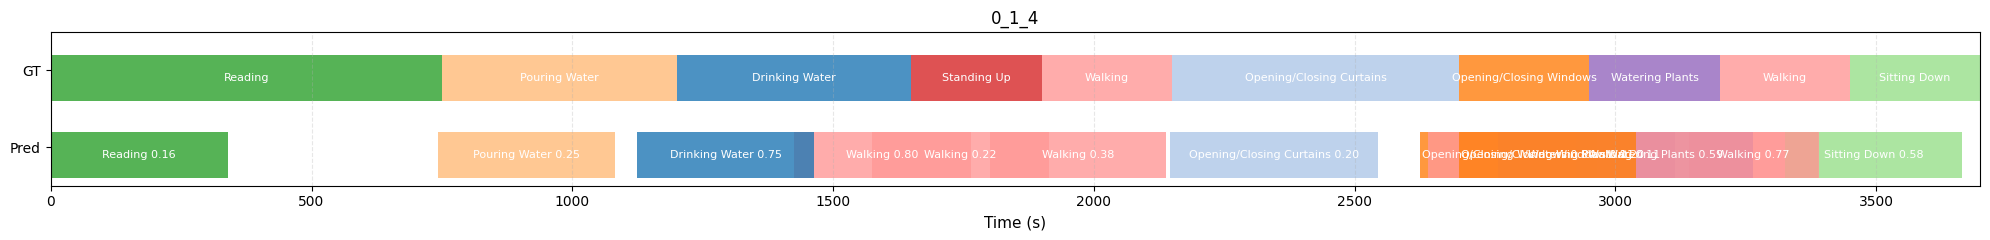

In [12]:
import os
import json
from typing import List, Dict, Tuple, Optional

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


# ===================== 1. 读取 GT / Pred =====================

def load_gt_for_video(
    gt_path: str,
    video_id: str,          # 传不带 .h5 的，如 "0_1_3"
    subset: Optional[str] = None,
) -> Tuple[List[Dict], float]:
    """
    从 ActivityNet 风格 GT json 中取出某个 video 的标注。

    返回:
      gt_list: [{"label": str, "start": float, "end": float}, ...]
      duration: float
    """
    with open(gt_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    database = data["database"]

    # GT 里是 "0_1_3.h5"，预测是 "0_1_3" → 这里自动对齐
    key = video_id
    if key not in database and f"{video_id}.h5" in database:
        key = f"{video_id}.h5"

    if key not in database:
        raise KeyError(f"[load_gt_for_video] video_id '{video_id}' not found in GT (tried '{video_id}' and '{video_id}.h5')")

    vid_info = database[key]

    # 可选检查 subset
    if subset is not None and vid_info.get("subset", None) != subset:
        print(f"[load_gt_for_video] Warning: video '{key}' subset={vid_info.get('subset')} "
              f"but you specified subset='{subset}'")

    duration = float(vid_info.get("duration", 0.0))

    gt_list = []
    for ann in vid_info["annotations"]:
        seg = ann["segment"]  # [start, end]
        gt_list.append({
            "label": ann["label"],
            "start": float(seg[0]),
            "end": float(seg[1]),
        })

    return gt_list, duration


def load_pred_for_video(
    pred_path: str,
    video_id: str,          # 这里就是预测 json 中的 key，比如 "0_1_3"
    score_thresh: float = 0.0,
    top_k: Optional[int] = None,
) -> List[Dict]:
    """
    从 ActivityNet 风格 prediction json 里，取出某个 video 的预测。

    返回:
      [{"label": str, "start": float, "end": float, "score": float}, ...]
    """
    with open(pred_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    results = data["results"]
    if video_id not in results:
        print(f"[load_pred_for_video] Warning: video_id '{video_id}' not found in prediction results")
        return []

    preds_raw = results[video_id]
    preds = []
    for p in preds_raw:
        sc = float(p["score"])
        if sc < score_thresh:
            continue
        seg = p["segment"]
        preds.append({
            "label": p["label"],
            "start": float(seg[0]),
            "end": float(seg[1]),
            "score": sc,
        })

    preds.sort(key=lambda x: x["score"], reverse=True)
    if top_k is not None:
        preds = preds[:top_k]
    return preds


# ===================== 2. 颜色映射 =====================

def build_color_map(labels: List[str]):
    """
    给每个 label 分配一种颜色，用 matplotlib 的 tab20 调色板。
    """
    cmap = plt.get_cmap("tab20")
    uniq_labels = sorted(set(labels))
    color_map = {lab: cmap(i % cmap.N) for i, lab in enumerate(uniq_labels)}
    return color_map


# ===================== 3. 画一条视频时间轴 =====================

def plot_video_timeline(
    video_id: str,
    gt_list: List[Dict],
    pred_list: List[Dict],
    duration: Optional[float] = None,
    save_path: Optional[str] = None,
    dpi: int = 100,
):
    """
    在同一张图中画出：
      - 上面一条：GT（真值时间段）
      - 下面一条：Pred（预测时间段，带置信度）

    每个动作用不同颜色，预测框上叠加 "label + score" 文本。
    """

    # 决定时间轴长度，如果 duration 没给，就根据 GT/Pred 最大结束时间来定
    if duration is None or duration <= 0:
        max_gt = max((g["end"] for g in gt_list), default=0.0)
        max_pred = max((p["end"] for p in pred_list), default=0.0)
        duration = max(max_gt, max_pred)

    # 防止极端数值导致 Matplotlib 计算出巨大画布
    if duration <= 0:
        duration = 1.0
    if duration > 10_000:  # 如果真有非常长的序列，这里做个保护
        print(f"[plot_video_timeline] Warning: duration={duration} too large, "
              f"clamp to 10_000 for visualization.")
        duration = 10_000.0

    # 整理所有出现过的动作标签，建立统一颜色映射
    all_labels = [g["label"] for g in gt_list] + [p["label"] for p in pred_list]
    color_map = build_color_map(all_labels)

    # 根据时长动态调一点宽度，但限制在合理范围内
    # 比如 duration≈30 秒 → 宽度 ~ 12 inch
    width_inch = min(max(duration / 3.0, 6.0), 20.0)  # [6, 20] 之间
    height_inch = 2.5

    fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)

    ax.set_xlim(0, duration)
    ax.set_ylim(0, 2)
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(["Pred", "GT"], fontsize=10)
    ax.set_xlabel("Time (s)", fontsize=11)
    ax.set_title(video_id, fontsize=12)

    # ========== 画 GT：y = 1.1 ~ 1.7 ==========
    for seg in gt_list:
        x0 = seg["start"]
        w = max(seg["end"] - seg["start"], 1e-3)  # 至少画出一点宽度
        lab = seg["label"]
        rect = Rectangle(
            (x0, 1.1), w, 0.6,
            color=color_map[lab],
            alpha=0.8,
            linewidth=0,
        )
        ax.add_patch(rect)
        ax.text(
            x0 + w / 2,
            1.4,
            lab,
            ha="center",
            va="center",
            fontsize=8,
            color="white",
        )

    # ========== 画 Pred：y = 0.1 ~ 0.7 ==========
    for seg in pred_list:
        x0 = seg["start"]
        w = max(seg["end"] - seg["start"], 1e-3)
        lab = seg["label"]
        score = seg["score"]
        rect = Rectangle(
            (x0, 0.1), w, 0.6,
            color=color_map[lab],
            alpha=0.8,
            linewidth=0,
        )
        ax.add_patch(rect)
        ax.text(
            x0 + w / 2,
            0.4,
            f"{lab} {score:.2f}",
            ha="center",
            va="center",
            fontsize=8,
            color="white",
        )

    # 竖向虚线网格，方便看重合度
    ax.grid(axis="x", linestyle="--", alpha=0.3)

    plt.tight_layout()

    # —— 先保存，再展示 ——
    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and not os.path.exists(save_dir):
            os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_path, dpi=dpi)
        print(f"[viz] saved figure to: {save_path}")

    # 在 notebook 里直接显示
    plt.show()

    # 关闭 figure，避免内存泄漏和重复显示
    plt.close(fig)


# ===================== 4. 一键可视化某个视频 =====================

def visualize_one_video(
    gt_path: str,
    pred_path: str,
    video_id: str,          # 传预测里的 id，比如 "0_1_3"
    subset: str = "test",
    score_thresh: float = 0.1,
    top_k: int = 30,
    save_path: Optional[str] = None,
):
    """
    直接给 GT json、Pred json、video_id，就画出一张图。
    """
    # 读 GT
    gt_list, duration = load_gt_for_video(
        gt_path=gt_path,
        video_id=video_id,
        subset=subset,
    )

    # 读 Pred
    pred_list = load_pred_for_video(
        pred_path=pred_path,
        video_id=video_id,
        score_thresh=score_thresh,
        top_k=top_k,
    )

    # 画图
    plot_video_timeline(
        video_id=video_id,
        gt_list=gt_list,
        pred_list=pred_list,
        duration=duration,
        save_path=save_path,
    )


# ===================== 5. 示例调用 =====================

if __name__ == "__main__":
    # 换成你自己的路径
    gt_json = "/root/autodl-tmp/WWADL/all_30_3/imu_annotations.json"
    pred_json = "/root/WSDDN/test_results/wsddn_spatial_reg/predictions.json"

    # 不带 .h5 的 video_id（跟预测 json 中的 key 一致）
    video_id = "0_1_4"

    out_dir = "/root/WSDDN/test_results/vis/vis_results"
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, f"{video_id}.png")

    visualize_one_video(
        gt_path=gt_json,
        pred_path=pred_json,
        video_id=video_id,
        subset="test",
        score_thresh=0.1,    # 只显示高于这个置信度的预测
        top_k=30,
        save_path=save_path,
    )


In [ ]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def _load_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def _load_gt_segments(gt_path, video_id, subset="test"):
    """
    兼容 ActivityNet 风格 GT:
    data["database"][video_id]["annotations"] 每条包含:
      - label: str
      - segment: [t0, t1]  (通常是秒；你的Opportunity也按秒)
    """
    with open(gt_path, "r", encoding="utf-8") as f:
        gt = json.load(f)

    info = gt["database"][video_id]
    if subset is not None and info.get("subset") != subset:
        # 你也可以这里不强行判断 subset
        pass

    segs = []
    for ann in info.get("annotations", []):
        label = ann.get("label", "unknown")
        t0, t1 = float(ann["segment"][0]), float(ann["segment"][1])
        if t1 > t0:
            segs.append((t0, t1, label))
    return segs

def _load_pred_segments(pred_path, video_id):
    """
    你的 predictions_test_full.json:
    data["results"][video_id] 每条包含:
      - label: str
      - score: float
      - segment: [t0, t1]
    """
    with open(pred_path, "r", encoding="utf-8") as f:
        pred = json.load(f)

    segs = []
    for r in pred["results"].get(video_id, []):
        label = r.get("label", "unknown")
        score = float(r.get("score", 0.0))
        t0, t1 = float(r["segment"][0]), float(r["segment"][1])
        if t1 > t0:
            segs.append((t0, t1, label, score))
    return segs

def _build_label2color(labels):
    # 类别多的话 tab20/tab20b/tab20c 都行
    cmap = plt.get_cmap("tab20")
    labels = list(labels)
    label2color = {lab: cmap(i % cmap.N) for i, lab in enumerate(labels)}
    return label2color

def plot_gt_pred_two_rows_inline(
    gt_path,
    pred_path,
    video_id="sbj_0",
    subset="test",
    # 这两个只是“画图筛选”，不想筛选就设为 None
    score_thresh=None,
    topk_total=None,
    figsize=(18, 4),
):
    gt_segs = _load_gt_segments(gt_path, video_id, subset=subset)

    pred_segs = _load_pred_segments(pred_path, video_id)
    pred_segs = suppress_diff_labels_drop(pred_segs)  # 不重叠可视化

    # ===== 可选：画图时再筛掉一些 pred，避免太密 =====
    if score_thresh is not None:
        pred_segs = [x for x in pred_segs if x[3] >= float(score_thresh)]
    if topk_total is not None:
        pred_segs = sorted(pred_segs, key=lambda x: x[3], reverse=True)[:int(topk_total)]

    # label全集，用于统一配色（GT/Pred 同色）
    all_labels = sorted({lab for _, _, lab in gt_segs} | {lab for _, _, lab, _ in pred_segs})
    label2color = _build_label2color(all_labels)

    # 时间范围
    t_min = min([t0 for t0, _, _ in gt_segs] + [t0 for t0, _, _, _ in pred_segs] + [0.0])
    t_max = max([t1 for _, t1, _ in gt_segs] + [t1 for _, t1, _, _ in pred_segs] + [1.0])

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlim(t_min, t_max)
    ax.set_ylim(0, 2)
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(["Pred", "GT"])
    ax.set_xlabel("Time (sec)")
    ax.set_title(f"GT vs Pred: {video_id}")

    bar_h = 0.6
    y_gt = 1.5 - bar_h / 2
    y_pr = 0.5 - bar_h / 2

    # ===== 关键修复：GT 不要用 black 写死；用 label2color[label] =====
    for t0, t1, lab in gt_segs:
        c = label2color.get(lab, (0, 0, 0, 1))
        ax.broken_barh([(t0, t1 - t0)], (y_gt, bar_h),
                       facecolors=c, edgecolors=c, alpha=0.9, linewidth=1.0)

    # Pred：同色系，但更透明一些，便于和 GT 区分
    for t0, t1, lab, score in pred_segs:
        c = label2color.get(lab, (0, 0, 0, 1))
        ax.broken_barh([(t0, t1 - t0)], (y_pr, bar_h),
                       facecolors=c, edgecolors=c, alpha=0.45, linewidth=0.8)

    # 图例（按 label）
    handles = [mpatches.Patch(color=label2color[lab], label=lab) for lab in all_labels]
    ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.01, 1.0), borderaxespad=0.0)

    ax.grid(True, axis="x", linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()


# 不重叠可视化：
def overlap(a, b):
    return max(0.0, min(a[1], b[1]) - max(a[0], b[0]))

def merge_same_label(segs, gap=0.0):
    """同label重叠/相邻(gap内)就合并"""
    by = defaultdict(list)
    for t0,t1,lab,sc in segs:
        by[lab].append((t0,t1,lab,sc))
    out = []
    for lab, items in by.items():
        items.sort(key=lambda x: x[0])
        cur = list(items[0])
        for t0,t1,_,sc in items[1:]:
            if t0 <= cur[1] + gap:  # 重叠或相邻
                cur[1] = max(cur[1], t1)
                cur[3] = max(cur[3], sc)
            else:
                out.append(tuple(cur))
                cur = [t0,t1,lab,sc]
        out.append(tuple(cur))
    out.sort(key=lambda x: x[0])
    return out

def suppress_diff_labels_drop(pred_segs):
    """
    不同label只要有任何重叠：保留分高的，低分整段丢掉（贪心）
    """
    segs = [(float(t0), float(t1), str(lab), float(sc)) for t0,t1,lab,sc in pred_segs if float(t1) > float(t0)]
    segs.sort(key=lambda x: x[3], reverse=True)  # 高分优先
    kept = []
    for t0,t1,lab,sc in segs:
        conflict = any((lab != klab) and overlap((t0,t1),(kt0,kt1)) > 0 for kt0,kt1,klab,ksc in kept)
        if conflict:
            continue
        kept.append((t0,t1,lab,sc))
    # 最后同类合并
    return merge_same_label(kept, gap=0.0)
# plot_gt_pred_timeline_inline(
#     gt_path=gt_path,
#     pred_path=pred_path,
#     video_id="sbj_0",
#     subset="test",
#     score_thresh=0.01,
#     max_pred_per_label=80,
# )

# Opportunity
gt_path = "/home/lipei/project/WSDDN/test_results/Opportunity/pcl_0106/fold0/gt_for_anet.json"
pred_path = "/home/lipei/project/WSDDN/test_results/Opportunity/pcl_0106/fold0/predictions_test_full.json"

# RWHAR
# gt_path = "/home/lipei/project/WSDDN/test_results/RWHAR/wsddn_0105/fold0/gt_for_anet.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/RWHAR/wsddn_0105/fold0/predictions_test_full.json"

# SBHAR
# gt_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0105/fold0/gt_for_anet.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0105/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0105/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0103/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/SBHAR/wsddn_0103/fold0/predictions_test_window.json"

# WEAR
# gt_path = "/home/lipei/project/WSDDN/test_results/WEAR/wsddn_0105/fold0/gt_for_anet.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/wsddn_0105/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/wsddn_0105/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/oicr_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/oicr_0103/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/pcl_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WEAR/pcl_0103/fold0/predictions_test_window.json"

# WEAR
# gt_path = "/home/lipei/project/WSDDN/test_results/WETLAB/wsddn_0105/fold0/gt_for_anet.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETLAB/wsddn_0105/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETLAB/wsddn_0105/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETLAB/oicr_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETLAB/oicr_0103/fold0/predictions_test_window.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETALB/pcl_0103/fold0/predictions_test_full.json"
# pred_path = "/home/lipei/project/WSDDN/test_results/WETALB/pcl_0103/fold0/predictions_test_window.json"

plot_gt_pred_two_rows_inline(
    gt_path=gt_path,
    pred_path=pred_path,
    video_id="sbj_0",
    subset="test",
    # score_thresh=0.01,
    # topk_total=400,   # 预测多就调小点
)